In [24]:
import h5py
import numpy as np
import torch
import torch.nn.functional as F

# Define the HDF5 file path
hdf5_filepath = '/Users/iangill/Downloads/test_MuSHrooM_all_fields.h5'
output_filepath = '/Users/iangill/Downloads/test_MuSHrooM_all_fields_small.h5'

# Read and process the data
with h5py.File(hdf5_filepath, 'r') as f:
    # Read the datasets
    tempIon_data = f['tempIon_data'][:]
    denIon_data = f['denIon_data'][:]
    tempElc_data = f['tempElc_data'][:]
    denElc_data = f['denElc_data'][:]
    phi_data = f['phi_data'][:]
    times = f['times'][:]
    grid = f['X'][:]
    
    # Read the attributes (dimensions of data)
    Nx = f.attrs['Nx']
    Ny = f.attrs['Ny']
    Nt = f.attrs['Nt']

# Transpose phi_data
phi_data = np.transpose(phi_data, (2, 1, 0))
denIon_data = np.transpose(denIon_data, (2, 1, 0))
tempElc_data = np.transpose(tempElc_data, (2, 1, 0))
denElc_data = np.transpose(denElc_data, (2, 1, 0))
tempIon_data = np.transpose(tempIon_data, (2, 1, 0))


# Function to downsample a field to 128x128 using F.interpolate
def downsample_to_128x128(data):
    # Convert the data to a PyTorch tensor and add batch and channel dimensions
    tensor = torch.tensor(data, dtype=torch.float32)
    if tensor.ndim == 3:  # Handle 3D data (Nt, Ny, Nx)
        tensor = tensor.unsqueeze(1)  # Add a channel dimension (Nt, 1, Ny, Nx)
    elif tensor.ndim == 4:  # Handle 4D data (e.g., for multiple variables)
        tensor = tensor.unsqueeze(2)  # Add a new dimension to align shape

    # Downsample to 128x128
    tensor_downsampled = F.interpolate(
        tensor,
        size=(128, 128),
        mode='bilinear',
        align_corners=False
    )

    # Remove the channel dimension
    if tensor_downsampled.shape[1] == 1:
        tensor_downsampled = tensor_downsampled.squeeze(1)

    return tensor_downsampled.numpy()

# Downsample all fields to 128x128
phi_data_downsampled = downsample_to_128x128(phi_data)
print(phi_data_downsampled.shape)
tempIon_data_downsampled = downsample_to_128x128(tempIon_data)
denIon_data_downsampled = downsample_to_128x128(denIon_data)
tempElc_data_downsampled = downsample_to_128x128(tempElc_data)
denElc_data_downsampled = downsample_to_128x128(denElc_data)

# Save the processed data to a new HDF5 file
with h5py.File(output_filepath, 'w') as f:
    # Save datasets
    f.create_dataset('phi_data', data=phi_data_downsampled)
    f.create_dataset('tempIon_data', data=tempIon_data_downsampled)
    f.create_dataset('denIon_data', data=denIon_data_downsampled)
    f.create_dataset('tempElc_data', data=tempElc_data_downsampled)
    f.create_dataset('denElc_data', data=denElc_data_downsampled)
    f.create_dataset('times', data=times)
    f.create_dataset('grid', data=grid)
    
    # Save attributes
    f.attrs['Nx'] = 128
    f.attrs['Ny'] = 128
    f.attrs['Nt'] = Nt  # Keep the original time dimension

print(f"Processed data saved to {output_filepath}")

(544, 128, 128)
Processed data saved to /Users/iangill/Downloads/test_MuSHrooM_all_fields_small.h5


In [ ]:
# general imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F

# data loading and processing
import h5py
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

hdf5_filepath = '/Users/iangill/Downloads/test_MuSHrooM_processed-60024954.h5'
with h5py.File(hdf5_filepath, 'r') as f:
    # Read the datasets
    #tempIon_data = f['tempIon_data'][:]
    #denIon_data = f['denIon_data'][:]
    #tempElc_data = f['tempElc_data'][:]
    #denElc_data = f['denElc_data'][:]
    phi_data = f['phi_data'][:]
    times = f['times'][:]
    grid = f['X'][:]
    # Read the attributes (dimensions of data)
    Nx = f.attrs['Nx']
    Ny = f.attrs['Ny']
    Nt = f.attrs['Nt']

phi_data = np.transpose(phi_data, (2, 1, 0))
print("Shape of data:", phi_data.shape)



[[-4.01058453e-05 -3.94273427e-05 -4.08487707e-05 ... -3.02956791e-05
  -3.25936604e-05 -3.91318028e-05]
 [-3.63544663e-05 -4.12444018e-05 -3.79457082e-05 ... -3.84012423e-05
  -3.62151604e-05 -2.98206949e-05]
 [-3.67277783e-05 -3.88534511e-05 -3.76502480e-05 ... -3.43533494e-05
  -2.90790382e-05 -3.57766532e-05]
 ...
 [-4.18358134e-05 -4.16202291e-05 -3.44037011e-05 ... -4.12722044e-05
  -3.95388825e-05 -4.28543990e-05]
 [-4.17010287e-05 -4.08291292e-05 -3.61093649e-05 ... -4.44339917e-05
  -4.33578221e-05 -4.45099562e-05]
 [-4.26931126e-05 -3.78134087e-05 -3.56040216e-05 ... -3.88133051e-05
  -4.23306340e-05 -4.62097821e-05]]
Shape of data: (1311, 682, 683)


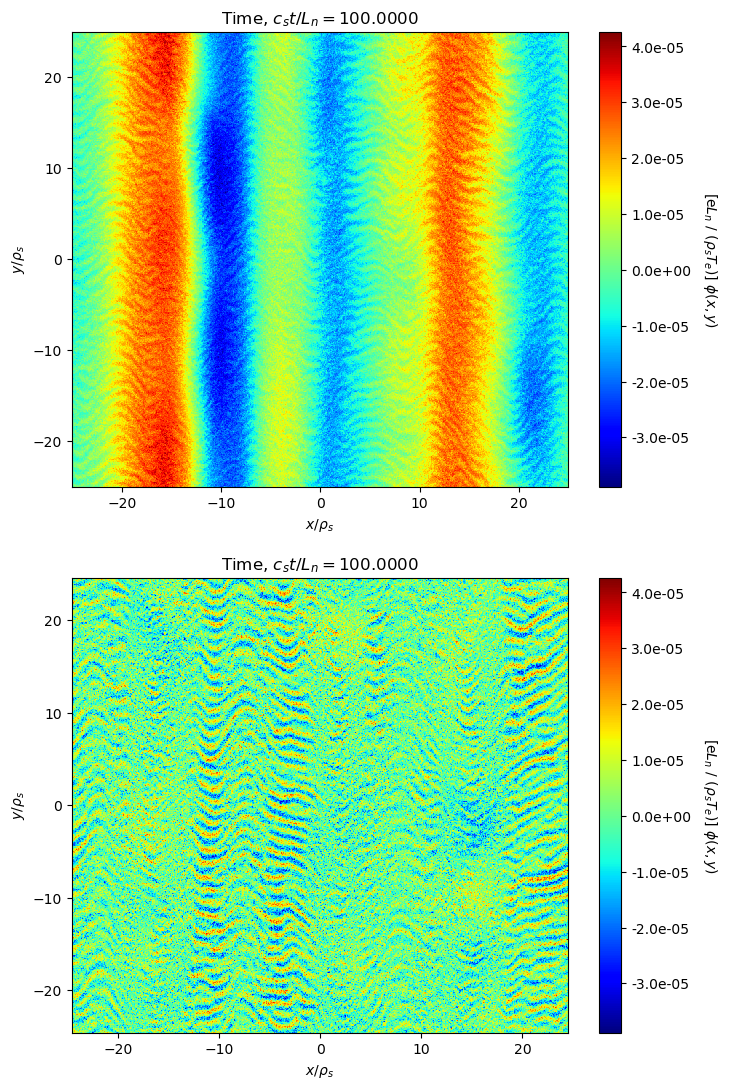

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Assuming grid and phi_data are already loaded
# grid[0, :, :] -> x-coordinates, grid[1, :, :] -> y-coordinates

# Define transform for resizing
input_dim = 64  # Target dimension for resizing
transform = transforms.Resize((input_dim, input_dim))  # Resizing to (64, 64)

# Select a test slice from phi_data
test = torch.tensor(phi_data[400, :, :].copy())  # Select test slice (2D spatial slice)
print(phi_data[1, :, :])

  # Add batch dimension for resizing

# Resize the x and y coordinate grids in `grid`
x_coords = torch.tensor(grid[0, :, :]).unsqueeze(0)  # Add batch dimension for resizing
y_coords = torch.tensor(grid[1, :, :]).unsqueeze(0)
fig, axs= plt.subplots(2,1,figsize=(8, 13))
ax1=axs[1]
ax2=axs[0]
cax2 = ax2.imshow(phi_data[400, :, :], cmap='jet', interpolation='nearest',
                extent=[x_coords.min(), x_coords.max(), 
                        y_coords.min(), y_coords.max()],
                origin='lower', aspect='auto')
test = test.unsqueeze(0)
resized_test = transform(test).squeeze().numpy()



resized_x_coords = transform(x_coords).squeeze().numpy()  # Resize x-coordinates
resized_y_coords = transform(y_coords).squeeze().numpy()  # Resize y-coordinates




#phi_data = torch.tensor(phi_data.copy())
#phi_data = transform(phi_data).numpy().astype(np.float32) 
print("Shape of data:", phi_data.shape)

def rescale(data):
    return (data ) / (np.max(data) - np.min(data))
#phi_data = rescale(phi_data)


cax = ax1.imshow(phi_data[1204,:,:]-phi_data[1203,:,:], cmap='jet', interpolation='nearest',
                extent=[resized_x_coords.min(), resized_x_coords.max(), 
                        resized_y_coords.min(), resized_y_coords.max()],
                origin='lower', aspect='auto')
cbar = fig.colorbar(cax, ax=ax2, format='%.1e')
cbar.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
cbar2 = fig.colorbar(cax, ax=ax1, format='%.1e')
cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)


time_value = times[0]  # Replace with dynamic time value if available
ax1.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax1.set_xlabel(r'$x / \rho_s$')
ax1.set_ylabel(r'$y / \rho_s$')
ax2.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax2.set_xlabel(r'$x / \rho_s$')
ax2.set_ylabel(r'$y / \rho_s$')
plt.show()

T inside model: tensor([[-0.5015, -0.4856, -0.4697, -0.4539, -0.4380, -0.4221, -0.4062, -0.3904,
         -0.3745, -0.3586, -0.3428, -0.3269, -0.3110, -0.2951, -0.2793, -0.2634,
         -0.2475, -0.2316, -0.2158, -0.1999, -0.1840, -0.1682, -0.1523, -0.1364,
         -0.1205, -0.1047, -0.0888, -0.0729, -0.0570, -0.0412, -0.0253, -0.0094,
          0.0065,  0.0223,  0.0382,  0.0541,  0.0699,  0.0858,  0.1017,  0.1176,
          0.1334,  0.1493,  0.1652,  0.1811,  0.1969,  0.2128,  0.2287,  0.2445,
          0.2604,  0.2763,  0.2922,  0.3080,  0.3239,  0.3398,  0.3557,  0.3715,
          0.3874,  0.4033,  0.4191,  0.4350,  0.4509,  0.4668,  0.4826,  0.4985]])
X inside model: tensor([[-0.5000, -0.4841, -0.4683, -0.4524, -0.4365, -0.4206, -0.4048, -0.3889,
         -0.3730, -0.3571, -0.3413, -0.3254, -0.3095, -0.2937, -0.2778, -0.2619,
         -0.2460, -0.2302, -0.2143, -0.1984, -0.1825, -0.1667, -0.1508, -0.1349,
         -0.1190, -0.1032, -0.0873, -0.0714, -0.0556, -0.0397, -0.0238, -0.

Text(0, 0.5, '$y / \\rho_s$')

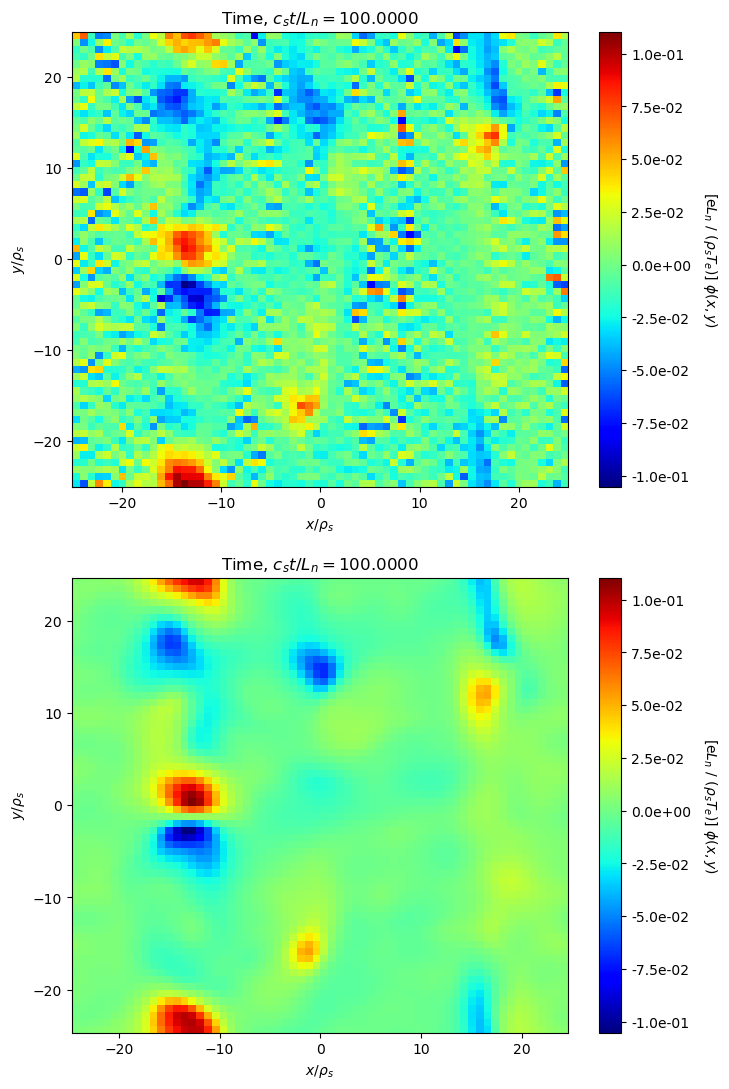

In [9]:
from LNO_model import LNO2d, Transient, Steady

input_dim=64
x_coords = torch.tensor(grid[0, :, :], dtype=torch.float32).unsqueeze(0)
y_coords = torch.tensor(grid[1, :, :], dtype=torch.float32).unsqueeze(0)



resized_x_coords = F.interpolate(x_coords.unsqueeze(0), size=(input_dim, input_dim), mode='bilinear', align_corners=False).squeeze()
resized_y_coords = F.interpolate(y_coords.unsqueeze(0), size=(input_dim, input_dim), mode='bilinear', align_corners=False).squeeze()
T=resized_x_coords[:,0].unsqueeze(0)
X=resized_y_coords[0,:].unsqueeze(0)

def rescale(data):
    return (data) / (torch.max(data) - torch.min(data))

T=rescale(T)
X=rescale(X)

modes11, modes12, modes21, modes22 = 4, 4, 4, 4
width1, width2, width3 = 16, 16, 16
model = LNO2d(width1, width2, width3, modes11, modes12, modes21, modes22)

state_dict = torch.load('LNO_difference_model_weights.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
setattr(model, 'T', T)
setattr(model, 'X', X)
for module in model.modules():
    if isinstance(module, Transient) or isinstance(module, Steady):
        module.T = T  # Assign the precomputed T tensor
        module.X = X  # Assign the precomputed X tensor

# Check if T and X are accessible within the model
print("T inside model:", model.T)
print("X inside model:", model.X)
input_data = torch.tensor(phi_data[204, :, :], dtype=torch.float32)  # Convert to PyTorch tensor
print(input_data.shape)
input_data = input_data.unsqueeze(0).unsqueeze(-1)  # Shape: [1, H, W, 1]
out=model(input_data).squeeze(0).squeeze(-1)
out=out.detach().numpy()



fig, axs= plt.subplots(2,1,figsize=(8, 13))
ax1=axs[1]
ax2=axs[0]

cax = ax1.imshow(out, cmap='jet', interpolation='nearest',
                extent=[resized_x_coords.min(), resized_x_coords.max(), 
                        resized_y_coords.min(), resized_y_coords.max()],
                origin='lower', aspect='auto')
cax2 = ax2.imshow(phi_data[205, :, :]-phi_data[204, :, :], cmap='jet', interpolation='nearest',
                extent=[x_coords.min(), x_coords.max(), 
                        y_coords.min(), y_coords.max()],
                origin='lower', aspect='auto')


cbar = fig.colorbar(cax, ax=ax2, format='%.1e')
cbar.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
cbar2 = fig.colorbar(cax, ax=ax1, format='%.1e')
cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)


time_value = times[0]  # Replace with dynamic time value if available
ax1.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax1.set_xlabel(r'$x / \rho_s$')
ax1.set_ylabel(r'$y / \rho_s$')
ax2.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax2.set_xlabel(r'$x / \rho_s$')
ax2.set_ylabel(r'$y / \rho_s$')


In [26]:
hdf5_filepath = '/Users/iangill/Downloads/test_MuSHrooM_all_fields_small.h5'

# Read and process the data
with h5py.File(hdf5_filepath, 'r') as f:
    # Read the datasets
    tempIon_data = f['tempIon_data'][:]
    denIon_data = f['denIon_data'][:]
    tempElc_data = f['tempElc_data'][:]
    denElc_data = f['denElc_data'][:]
    phi_data = f['phi_data'][:]
    times = f['times'][:]
    grid = f['grid'][:]
    
    # Read the attributes (dimensions of data)
    Nx = f.attrs['Nx']
    Ny = f.attrs['Ny']
    Nt = f.attrs['Nt']

In [ ]:
from LNO_model_AF import LNO2d, Transient, Steady

input_dim=64
x_coords = torch.tensor(grid[0, :, :], dtype=torch.float32).unsqueeze(0)
y_coords = torch.tensor(grid[1, :, :], dtype=torch.float32).unsqueeze(0)



resized_x_coords = F.interpolate(x_coords.unsqueeze(0), size=(input_dim, input_dim), mode='bilinear', align_corners=False).squeeze()
resized_y_coords = F.interpolate(y_coords.unsqueeze(0), size=(input_dim, input_dim), mode='bilinear', align_corners=False).squeeze()
T=resized_x_coords[:,0].unsqueeze(0)
X=resized_y_coords[0,:].unsqueeze(0)

def rescale(data):
    return (data) / (torch.max(data) - torch.min(data))

T=rescale(T)
X=rescale(X)

in_channels=5
modes11, modes12, modes21, modes22 = 4, 4, 4, 4
width1, width2, width3 = 16, 16, 16
model = LNO2d(in_channels,width1, width2, width3, modes11, modes12, modes21, modes22)

state_dict = torch.load('LNO_difference_AF_weights.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
setattr(model, 'T', T)
setattr(model, 'X', X)
for module in model.modules():
    if isinstance(module, Transient) or isinstance(module, Steady):
        module.T = T  # Assign the precomputed T tensor
        module.X = X  # Assign the precomputed X tensor

# Check if T and X are accessible within the model
print("T inside model:", model.T)
print("X inside model:", model.X)
input_data = torch.tensor(phi_data[540, :, :], dtype=torch.float32)  # Convert to PyTorch tensor
print(input_data.shape)
input_data = input_data.unsqueeze(0).unsqueeze(-1)  # Shape: [1, H, W, 1]
out=model(input_data).squeeze(0).squeeze(-1)
out=out.detach().numpy()



fig, axs= plt.subplots(2,1,figsize=(8, 13))
ax1=axs[1]
ax2=axs[0]

cax = ax1.imshow(out, cmap='jet', interpolation='nearest',
                extent=[resized_x_coords.min(), resized_x_coords.max(), 
                        resized_y_coords.min(), resized_y_coords.max()],
                origin='lower', aspect='auto')
cax2 = ax2.imshow(phi_data[541, :, :], cmap='jet', interpolation='nearest',
                extent=[x_coords.min(), x_coords.max(), 
                        y_coords.min(), y_coords.max()],
                origin='lower', aspect='auto')


cbar = fig.colorbar(cax, ax=ax2, format='%.1e')
cbar.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
cbar2 = fig.colorbar(cax, ax=ax1, format='%.1e')
cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)


time_value = times[0]  # Replace with dynamic time value if available
ax1.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax1.set_xlabel(r'$x / \rho_s$')
ax1.set_ylabel(r'$y / \rho_s$')
ax2.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax2.set_xlabel(r'$x / \rho_s$')
ax2.set_ylabel(r'$y / \rho_s$')
